In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../Data_exploration_notebooks')

from WranglerFunctions import CostsWrangler
from WranglerFunctions import F3Metl_Comp_Wrangler

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from numpy import log

# Silence ARIMA warnings
import warnings

warnings.filterwarnings("ignore")

In [73]:
RIO_costs = pd.read_csv('../Datasets/Financial_dataset/IncomeStatements/RIO_LN_BBG_GAAP.csv', index_col = False, encoding= 'unicode_escape')
RIO_costs = CostsWrangler(RIO, 'Revenue')

earnings = pd.read_csv('../Datasets/Financial_dataset/F3METL_Comp.csv', index_col=False, encoding = 'unicode_escape')
earnings = F3Metl_Comp_Wrangler(earnings)
RIO_earnings = earnings['RIO LN Equity']['EBITDA'].to_frame()
# RIO_earnings
RIO_costs = RIO_costs['Operating Expenses'].to_frame()

0


In [47]:
# Merge with a 3 day tolerance
tol = pd.Timedelta('3 day')
df = pd.merge_asof(left=RIO_costs,right=RIO_earnings,right_index=True,left_index=True,direction='nearest',tolerance=tol)
df

,Operating Expenses,EBITDA
Date,,
2010-12-31,23144.6,13406.0
2011-12-31,29362.9,12893.0
2012-12-31,33731.6,-6066.0
2013-12-31,28437.0,8038.0
2014-12-31,22606.1,8399.0
2015-12-31,20952.9,2898.0
2016-12-31,20538.3,4367.0
2017-12-31,20938.1,10209.0
2018-12-31,17865.1,13251.0


ADF Statistic: 1.277674
p-value: 0.996481
ADF Statistic: -1.836170
p-value: 0.362658
ADF Statistic: -4.031500
p-value: 0.001254


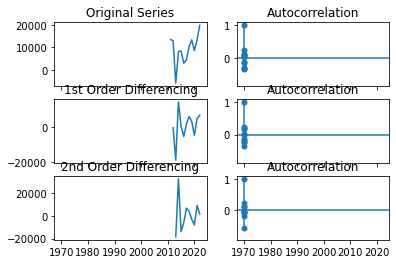

In [85]:
# Check if the data is stationary using the Augmented DIckey Fuller test
result = adfuller(df['EBITDA'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.EBITDA); axes[0, 0].set_title('Original Series')
plot_acf(df.EBITDA, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.EBITDA.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.EBITDA.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.EBITDA.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.EBITDA.diff().diff().dropna(), ax=axes[2, 1])

result = adfuller(df['EBITDA'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['EBITDA'].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 11 must be < 6.

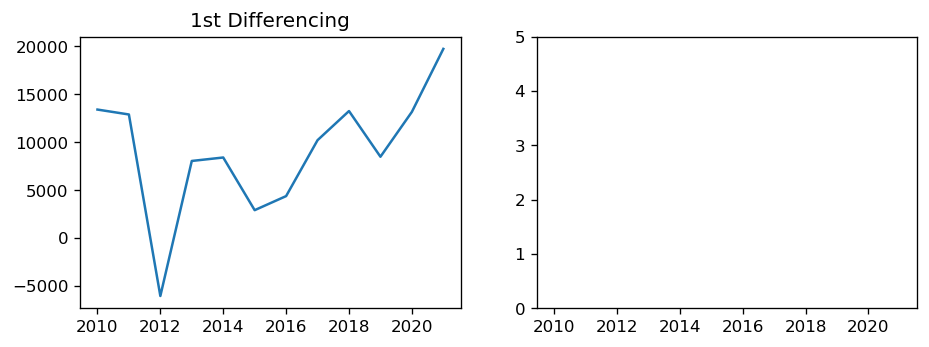

In [174]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.EBITDA); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df['EBITDA'].dropna(), ax=axes[1])

plt.show()

                             ARIMA Model Results                              
Dep. Variable:               D.EBITDA   No. Observations:                   10
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -104.687
Method:                       css-mle   S.D. of innovations           7559.458
Date:                Mon, 04 Apr 2022   AIC                            217.374
Time:                        21:17:25   BIC                            218.584
Sample:                             1   HQIC                           216.046
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            615.4826    997.308      0.617      0.537   -1339.206    2570.171
ar.L1.D.EBITDA    -0.9200      0.203     -4.536      0.000      -1.318      -0.523
ar.L2.D.EBITDA    -0.8044      0.195

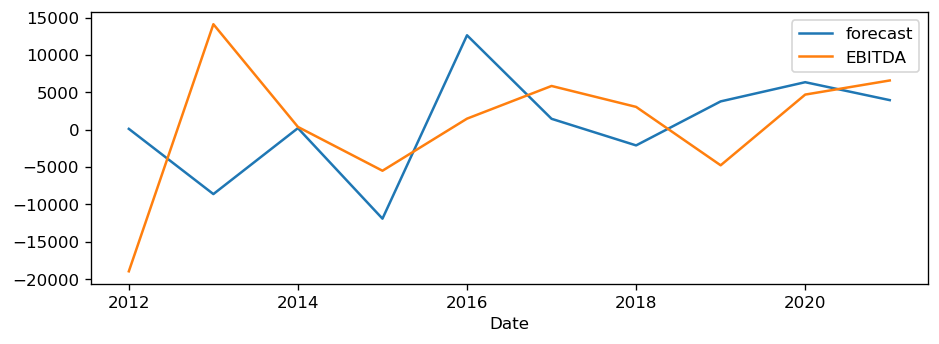

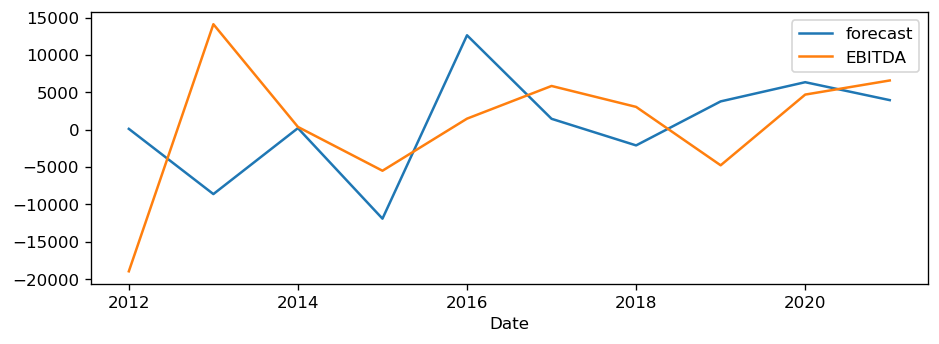

In [173]:
# 1,1,1 ARIMA Model
# model = ARIMA(df['Operating Expenses'].diff().dropna(), order=(2, 1, 0))
model = ARIMA(df['EBITDA'].diff().dropna(), order=(2, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
model_fit.plot_predict(dynamic=False)